# YAW pipeline testing 
To run this in production mode use `measure_yaw-w-random.py`.

In [1]:
# measure n(z)
import yaw
import os
import shutil
# check
import numpy as np
from astropy.io import fits
import pylab as pl

import healpy as hp

from yaw.correlation import autocorrelate_scalar, crosscorrelate_scalar
from yaw import autocorrelate
from yaw.utils import parallel

In [2]:
from yaw.correlation.corrfunc import ScalarCorrFunc

In [3]:
def delete_and_recreate_cache_directory(cache_dir):
    if parallel.on_root():  # if running with MPI, this is only executed on rank 0
        if os.path.exists(cache_dir):
            shutil.rmtree(cache_dir)
        os.mkdir(cache_dir)

In [4]:
njn=64
# here can test a range of scales
theta_min=[5,10,15]
theta_max=[15,30,50]
theta_scaled=None
resolution=None
unit='arcmin'

sim_mode_tag = "raw"
type_tag = "unknown"

ref_name = 'DELTA_F'
ref_weight_name = 'NPIX'

Delta F from raw catalog

In [5]:
sim_num = 0
unk_zcut = [1.8,3.0]

outroot = "/pscratch/sd/q/qhang/desi-lya/results/"

saveroot = outroot + f"run-{sim_num}/"
path_unknown = saveroot + f"catalogue/{type_tag}-zmin-{unk_zcut[0]}-zmax-{unk_zcut[1]}.fits"
path_reference = saveroot + f"catalogue/delta-{sim_mode_tag}.fits"
path_unk_rand = "/pscratch/sd/q/qhang/desi-lya/random-catalogue-overlap-zmin-1.8-w-z.fits"

In [6]:
# here use 40 bins, but we can test 20 bin case later:
edges = np.linspace(2,3,21)
zsamp = (edges[1:] + edges[:-1])/2.

In [7]:
# turn on logging to terminal (can change level to "info" or remove this line entirely)
#get_logger(level="info", pretty=True, capture_warnings=True)
PROGRESS = True  # if you want to see a progress bar

# CONFIGURATION
patch_num = njn # code will generate this number of patch centers from the reference randoms
config = yaw.Configuration.create(
    rmin=theta_min,  # scalar or list of lower scale cuts
    rmax=theta_max,
    unit=unit,
    rweight=theta_scaled,
    resolution=resolution,
    edges=edges,
)

In [9]:
# LOADING CATALOGS
CACHE_DIR = saveroot + f"yaw-20bin/cache_{sim_mode_tag}"
delete_and_recreate_cache_directory(CACHE_DIR)

In [10]:
# set up the catalogues:
cat_unknown = yaw.Catalog.from_file(
    cache_directory=os.path.join(CACHE_DIR, "unknown"),
    path=path_unknown,
    ra_name="RA",
    dec_name="DEC",
    redshift_name="Z",
    #weight_name="weight_column",  # optional
    patch_num=patch_num,
    progress=PROGRESS,
    degrees=True,
)
patch_centers = cat_unknown.get_centers()

processed 7/7 (100%) t=0m11.55s
processed 64/64 (100%) t=0m02.27s


In [11]:
cat_reference = yaw.Catalog.from_file(
    cache_directory=os.path.join(CACHE_DIR, "reference"),
    path=path_reference,
    ra_name="RA",
    dec_name="DEC",
    redshift_name="Z",
    weight_name=ref_weight_name,
    kappa_name=ref_name,
    patch_centers=patch_centers,
    progress=PROGRESS,
    degrees=True,
)

processed 1/1 (100%) t=0m01.32s
processed 64/64 (100%) t=0m01.62s


In [12]:
cat_ref_rand = None 

In [13]:
cat_unk_rand = yaw.Catalog.from_file(
    cache_directory=os.path.join(CACHE_DIR, "unk_rand"),
    path=path_unk_rand,
    ra_name="RA",
    dec_name="DEC",
    redshift_name="Z",
    patch_centers=patch_centers,
    progress=PROGRESS,
    degrees=True,
)

processed 11/11 (100%) t=0m19.90s
processed 64/64 (100%) t=0m03.03s


In [14]:
# measurements:
w_ss= autocorrelate_scalar(
    config,
    cat_reference,
    progress=PROGRESS
) # returns a list, one for each scale, just pick the first here
#   w_ss.to_file("...") -> store correlation pair counts as HDF5 file

processed 64/64 (100%) t=0m01.51s
processed 203/203 (100%) t=0m02.14s
processed 203/203 (100%) t=0m02.36s


/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:703: RuntimeWarning: invalid value encountered in divide
  data = kk_counts.data / nn_counts.data
/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:704: RuntimeWarning: invalid value encountered in divide
  samples = kk_counts.samples / nn_counts.samples


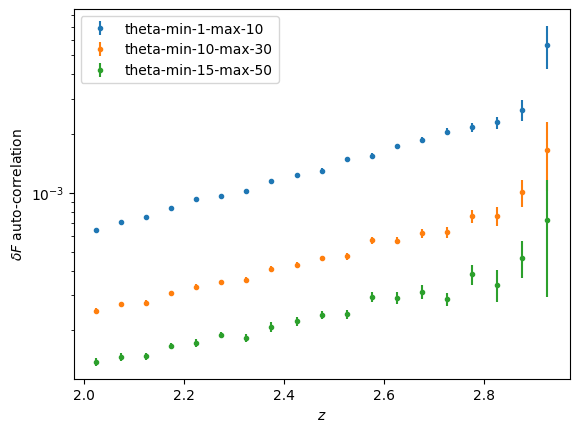

In [16]:
for ii in range(len(theta_min)):
    cts_ss = w_ss[ii]
    cts_ss.to_file(saveroot + f"yaw-20bin/w_ss-{sim_mode_tag}-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
    cts_ss.sample().plot(label=f"theta-min-{theta_min[ii]}-max-{theta_max[ii]}")
    pl.xlabel("$z$")
    pl.ylabel("$\\delta F$ auto-correlation")
    pl.yscale('log')
    pl.legend()

In [17]:
w_sp = crosscorrelate_scalar(
    config,
    cat_reference,
    cat_unknown,
    unk_rand=cat_unk_rand,
    progress=True,  # shows a progress bar, default: False
)

processed 64/64 (100%) t=0m01.46s
processed 64/64 (100%) t=0m04.20s
processed 64/64 (100%) t=0m07.57s
processed 346/346 (100%) t=2m07.65s
processed 346/346 (100%) t=1m57.54s
processed 346/346 (100%) t=3m16.67s
processed 346/346 (100%) t=3m18.15s


/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:703: RuntimeWarning: invalid value encountered in divide
  data = kk_counts.data / nn_counts.data
/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:704: RuntimeWarning: invalid value encountered in divide
  samples = kk_counts.samples / nn_counts.samples


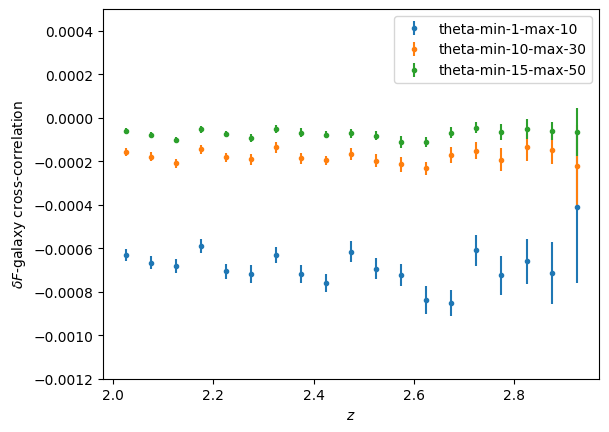

In [18]:
for ii in range(len(theta_min)):
    cts_sp = w_sp[ii]
    cts_sp.to_file(saveroot + f"yaw-20bin/w_sp-{sim_mode_tag}-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
    cts_sp.sample().plot(label=f"theta-min-{theta_min[ii]}-max-{theta_max[ii]}")
    pl.xlabel("$z$")
    pl.ylabel("$\\delta F$-galaxy cross-correlation")
    #pl.yscale('log')
    pl.legend()
    pl.ylim([-0.0012,0.0005])

In [20]:
wppfname = saveroot + f"yaw-20bin/w_pp-theta-min-{theta_min[0]}-max-{theta_max[0]}.hdf5"
if os.path.isfile(wppfname)!=True:
    # also run unknown case:
    w_pp = autocorrelate(
        config,
        cat_unknown,
        random=cat_unk_rand,
        progress=PROGRESS
    )
    for ii in range(len(theta_min)):
        cts_pp = w_pp[ii]
        cts_pp.to_file(saveroot + f"yaw-20bin/w_pp-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")

processed 64/64 (100%) t=0m04.13s
processed 64/64 (100%) t=0m06.04s
processed 205/205 (100%) t=1m06.42s
processed 346/346 (100%) t=1m30.09s
processed 205/205 (100%) t=2m11.89s


Text(0, 0.5, 'galaxy auto-correlation')

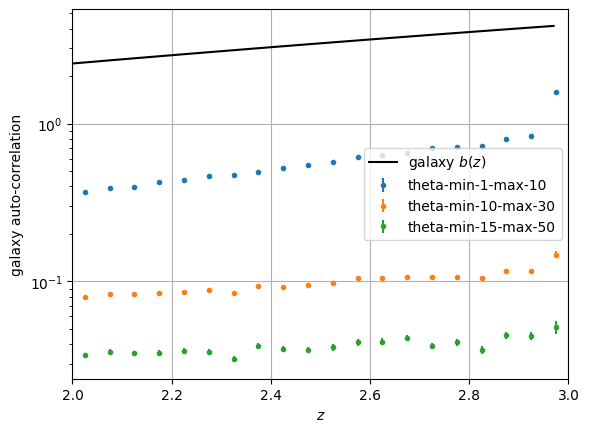

In [21]:
for ii in range(len(theta_min)):
    cts_pp = w_pp[ii]
    cts_pp.sample().plot(label=f"theta-min-{theta_min[ii]}-max-{theta_max[ii]}")

pl.yscale('log')
pl.grid()

# load and plot bias evolution curve:
bz = np.loadtxt("../bias_dc2.txt")
pl.plot(bz[:,0],bz[:,1],label="galaxy $b(z)$",color='k')
pl.xlim([2,3])

pl.legend()

pl.xlabel("$z$")
pl.ylabel("galaxy auto-correlation")

In [22]:
# load back the correlations:
w_ss=[]
w_sp=[]
w_pp=[]
for ii in range(len(theta_min)):
    fname = saveroot + f"yaw-20bin/w_ss-{sim_mode_tag}-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5"
    w_ss.append(ScalarCorrFunc.from_file(fname))

    fname = saveroot + f"yaw-20bin/w_sp-{sim_mode_tag}-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5"
    w_sp.append(ScalarCorrFunc.from_file(fname))

    fname = saveroot + f"yaw-20bin/w_pp-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5"
    w_pp.append(yaw.CorrFunc.from_file(fname))

In [23]:
nz_true = np.loadtxt("/pscratch/sd/q/qhang/desi-lya/nz-gal-z1.8-3.0-box-0-interp-for-rand.txt")
ind=(nz_true[:,1]>0)
nz_dz = nz_true[1,0] - nz_true[0,0]
nz_norm = (nz_true[:,1]/np.sum(nz_true[:,1])/nz_dz)[ind]
nz_zsamp = nz_true[ind,0]

Text(0.5, 1.0, '$n(z) = w_{\\rm ru}/\\sqrt{w_{\\rm rr} w_{\\rm uu}}\\Delta z$')

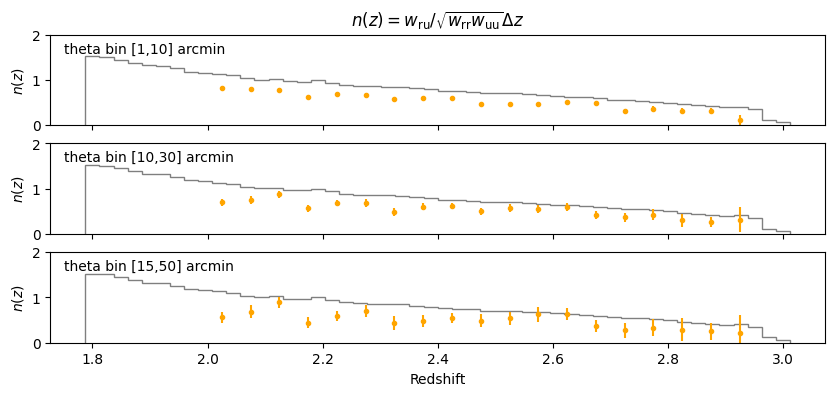

In [43]:
fig,axarr=pl.subplots(3,figsize=[10,4],sharex=True)

for ii in range(len(theta_min)):
    pl.sca(axarr[ii])
    
    cts_sp = w_sp[ii]
    cts_ss = w_ss[ii]
    cts_pp = w_pp[ii]
    
    zz = cts_sp.binning.mids
    sp = cts_sp.sample().data
    ss = cts_ss.sample().data
    pp = cts_pp.sample().data

    # get errorbar:
    samps = cts_sp.sample().samples/np.sqrt((cts_ss.sample().samples)*(cts_pp.sample().samples))
    std = np.std(samps,axis=0)*np.sqrt(64)
    
    deltaz = zz[1]-zz[0]
    pl.errorbar(zz, -sp/np.sqrt(ss*pp)/deltaz,yerr=std/deltaz,fmt='.',color='orange')
    
    # get true redshift distribution from sim:
    nz_edges = np.append(nz_zsamp-nz_dz/2., nz_zsamp[-1]+nz_dz/2.)
    pl.stairs(nz_norm,nz_edges, color='k', alpha=0.5)
    
    pl.ylabel("$n(z)$")
    pl.ylim([0,2])

    pl.text(1.75,1.6,f"theta bin [{theta_min[ii]},{theta_max[ii]}] arcmin")
pl.xlabel("Redshift")
pl.sca(axarr[0])
pl.title("$n(z) = w_{\\rm ru}/\\sqrt{w_{\\rm rr} w_{\\rm uu}}\\Delta z$")

Text(0.5, 1.0, '$n(z) \\propto w_{\\rm ru}/\\sqrt{w_{\\rm rr}}\\Delta z$')

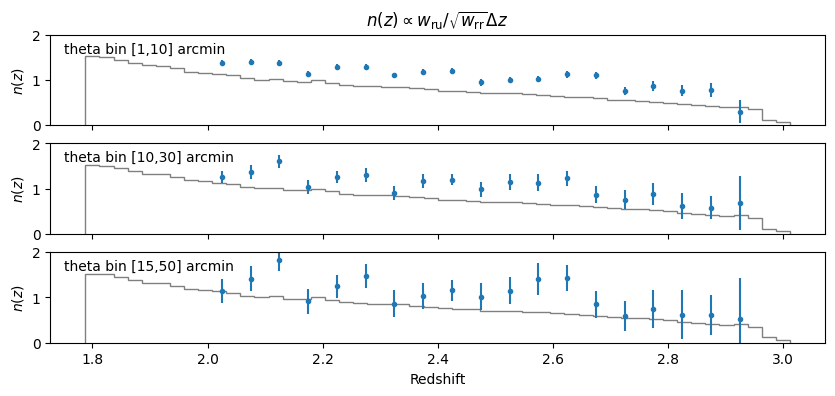

In [59]:
fig,axarr=pl.subplots(3,figsize=[10,4],sharex=True)

# here using yaw without the w_pp information:
for ii in range(len(theta_min)):
    pl.sca(axarr[ii])
    
    cts_sp = w_sp[ii]
    cts_ss = w_ss[ii]
    #cts_pp = w_pp[ii]
    ncc = yaw.RedshiftData.from_corrfuncs(
        cross_corr=cts_sp,
        ref_corr=cts_ss,
        unk_corr=None,
    )
    
    # or even with estimated normalisation
    ncc.normalised().plot()
    
    pl.ylabel("$n(z)$")
    pl.ylim([0,2])
    pl.text(1.75,1.6,f"theta bin [{theta_min[ii]},{theta_max[ii]}] arcmin")
    
    # get true redshift distribution from sim:
    nz_edges = np.append(nz_zsamp-nz_dz/2., nz_zsamp[-1]+nz_dz/2.)
    pl.stairs(nz_norm,nz_edges, color='k', alpha=0.5)
    #pl.stairs(cc[0]/sum(cc[0])/0.05, cc[1], color='k', alpha=0.5)
pl.xlabel("Redshift")
pl.sca(axarr[0])
pl.title("$n(z) \\propto w_{\\rm ru}/\\sqrt{w_{\\rm rr}}\\Delta z$")

### get same binning n(z) for unknown catalog

In [47]:
fin=fits.open(saveroot + "catalogue/unknown-zmin-1.8-zmax-3.0.fits")

In [56]:
cc=np.histogram(fin[1].data['Z'][::100], range=[2,3], bins=24)

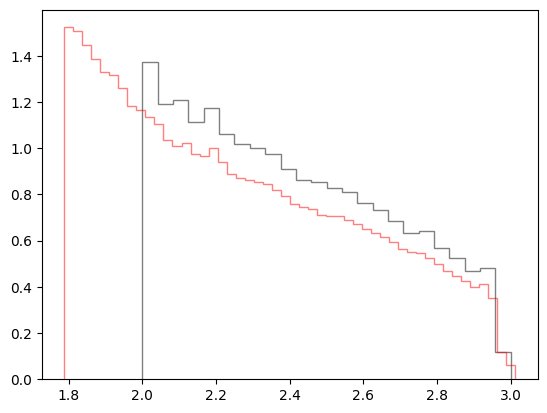

In [57]:
pl.stairs(cc[0]/sum(cc[0])/0.05, cc[1], color='k', alpha=0.5)

pl.stairs(nz_norm,nz_edges, color='r', alpha=0.5)